In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})
from matplotlib.ticker import FuncFormatter
import numpy as np
import darksector as ds
import standardmodel as sm
import sid
import constants as c
import pickle
from scipy import special, interpolate, optimize, fft

# Load the data

## Rho calc no theta (Default)

In [2]:
# Should probably change this whole section so that it is loaded in a more efficient way

# Load the pickle file with the data
with open('results/rho_computation_no_theta.pkl', 'rb') as file:
    data_dict = pickle.load(file)

ms_idx = 51

T_SM_final = data_dict['T_SM_domain'][0,ms_idx:,-1]
rho_DS_final = data_dict['rho_DS_domain'][0,ms_idx:,-1]

# Get the final dark sector temperature for each point in the parameter space
ms1_values = data_dict['ms1_values'][ms_idx:]
sinsq2theta_base = data_dict['sinsq2theta_values'][0]

# Get the dark sector temperature today
scale_factor_ratio, T_DS_final = np.zeros(len(ms1_values)), np.zeros(len(ms1_values))
for j, ms1 in enumerate(ms1_values):
    T_DS_final[j] = ds.find_T_DS_from_rho(rho_DS_final[j], ms1, 0)[0]
    scale_factor_ratio[j] = ds.T_SM_to_a(T_SM_final[j])/ds.T_SM_to_a(2) # Ratio from T_SM_final to 2 MeV 
    scale_factor_ratio[j] *= c.Tcnub/2 # Ratio from 2 MeV to today

T_DS_interp = interpolate.interp1d(ms1_values, T_DS_final, kind='linear', bounds_error=True)
T_SM_interp = interpolate.interp1d(ms1_values, T_SM_final, kind='linear', bounds_error=True)
scale_factor_interp = interpolate.interp1d(ms1_values, scale_factor_ratio, kind='linear', bounds_error=True)
# Create a dense 2D grid with dimensions (sinsq2theta, ms1)
num = 100
ms1_dense = np.logspace(np.log10(np.min(ms1_values)), np.log10(np.max(ms1_values)), num)
sinsq2theta_dense = np.logspace(-25, -10, num)

T_DS_dense, scale_factor_dense, T_DS_dense_today, T_SM_dense = [], [], [], []
for ms1 in ms1_dense:
    for sinsq2theta in sinsq2theta_dense:
        theta_scaling = (sinsq2theta/sinsq2theta_base)**(1./4)
        T_DS_dense.append(T_DS_interp(ms1)*theta_scaling)
        scale_factor = scale_factor_interp(ms1)
        scale_factor_dense.append(scale_factor)
        T_DS_dense_today.append(T_DS_interp(ms1)*theta_scaling*scale_factor)
        T_SM_dense.append(T_SM_interp(ms1))

T_DS_dense = np.array(T_DS_dense).reshape((num, num))
T_SM_dense = np.array(T_SM_dense).reshape((num, num))
scale_factor_dense = np.array(scale_factor_dense).reshape((num, num))
T_DS_dense_today = np.array(T_DS_dense_today).reshape((num, num))

## temperature calc

In [3]:
# Load the pickle file with the data
with open('data/T_DS_results.pkl', 'rb') as file:
    data_dict = pickle.load(file)

T_SM_final = data_dict['T_SM_domain'][-1]
T_DS_interp = interpolate.RegularGridInterpolator((data_dict['sinsq2theta_values'], ms1_values), 
                                                  data_dict['T_DS_domain'][:,:,0,-1], method='linear')
# Create a dense 2D grid of T_DS values, with dimensions (sinsq2theta, ms1)
num = 100
ms1_dense = np.logspace(np.log10(np.min(data_dict['ms1_values'])), np.log10(np.max(data_dict['ms1_values'])), num)
sinsq2theta_dense = np.logspace(np.log10(np.min(data_dict['sinsq2theta_values'])), np.log10(np.max(data_dict['sinsq2theta_values'])), num)

T_DS_dense = []
for ms1 in ms1_dense:
    for sinsq2theta in sinsq2theta_dense:
        T_DS_dense.append(T_DS_interp((sinsq2theta, ms1)))
T_DS_dense = np.array(T_DS_dense).reshape((len(ms1_dense), len(sinsq2theta_dense)))

# Convert to the temperature today, given the dilution from the decrease in relativistic degrees of freedom
scale_factor_ratio = (c.Tcmb/T_SM_final)*(sm.compute_SM_relativistic_dof_approx(c.Tcmb)/sm.compute_SM_relativistic_dof_approx(T_SM_final))**(1/3.0)
T_DS_dense_today = T_DS_dense*scale_factor_ratio


ValueError: There are 70 points and 7 values in dimension 1

## Rho calc

In [4]:
# Load the pickle file with the data
with open('results/rho_computation.pkl', 'rb') as file:
    data_dict = pickle.load(file)

T_SM_final = data_dict['T_SM_domain'][:,:,-1]
rho_DS_final = data_dict['rho_DS_domain'][:,:,-1]

# Get the final dark sector temperature for each point in the parameter space
ms1_values = data_dict['ms1_values']
sinsq2theta_values = data_dict['sinsq2theta_values']

scale_factor_ratio = np.zeros((len(sinsq2theta_values), len(ms1_values)))
T_DS_final = np.zeros((len(sinsq2theta_values), len(ms1_values)))
for i, sinsq2theta in enumerate(sinsq2theta_values):
    for j, ms1 in enumerate(ms1_values):
        T_DS_final[i,j] = ds.find_T_DS_from_rho(rho_DS_final[i,j], ms1, 0)[0]
        # Convert to the temperature today, given the dilution from the decrease in relativistic degrees of freedom
        # annihilation may not be treated correctly
        scale_factor_ratio[i,j] = (c.Tcmb/T_SM_final[i,j])*(sm.compute_SM_relativistic_dof_approx(c.Tcmb)/sm.compute_SM_relativistic_dof_approx(T_SM_final[i,j]))**(1/3.0)

T_DS_interp = interpolate.RegularGridInterpolator((sinsq2theta_values, ms1_values), T_DS_final, method='linear')
T_SM_interp = interpolate.RegularGridInterpolator((sinsq2theta_values, ms1_values), T_SM_final, method='linear')
scale_factor_interp = interpolate.RegularGridInterpolator((sinsq2theta_values, ms1_values), scale_factor_ratio, method='linear')
# Create a dense 2D grid with dimensions (sinsq2theta, ms1)
num = 100
ms1_dense = np.logspace(np.log10(np.min(ms1_values)), np.log10(np.max(ms1_values)), num)
sinsq2theta_dense = np.logspace(np.log10(np.min(sinsq2theta_values)), np.log10(np.max(sinsq2theta_values)), num)

T_DS_dense, scale_factor_dense, T_DS_dense_today, T_SM_dense = [], [], [], []
for ms1 in ms1_dense:
    for sinsq2theta in sinsq2theta_dense:
        T_DS_dense.append(T_DS_interp((sinsq2theta, ms1)))
        scale_factor = scale_factor_interp((sinsq2theta, ms1))
        scale_factor_dense.append(scale_factor)
        T_DS_dense_today.append(T_DS_interp((sinsq2theta, ms1))*scale_factor)
        T_SM_dense.append(T_SM_interp((sinsq2theta, ms1)))

T_DS_dense = np.array(T_DS_dense).reshape((len(ms1_dense), len(sinsq2theta_dense)))
T_SM_dense = np.array(T_SM_dense).reshape((len(ms1_dense), len(sinsq2theta_dense)))
scale_factor_dense = np.array(scale_factor_dense).reshape((len(ms1_dense), len(sinsq2theta_dense)))
T_DS_dense_today = np.array(T_DS_dense_today).reshape((len(ms1_dense), len(sinsq2theta_dense)))

FileNotFoundError: [Errno 2] No such file or directory: 'results/rho_computation.pkl'

# Results

## $T_{DS}/T_{SM}$

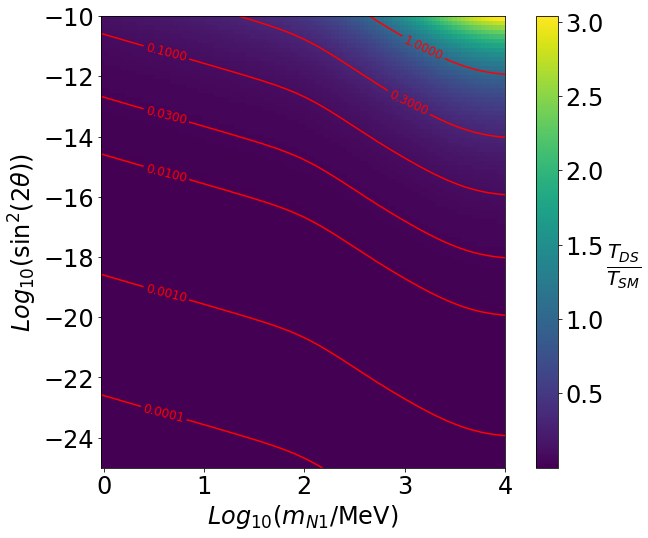

In [3]:
temp_ratio = T_DS_dense_today/c.Tcmb

plt.figure(figsize=(8,8))
im = plt.imshow(temp_ratio.T, origin='lower',
                  extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
levels = [0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1]
contours = plt.contour(X, Y, temp_ratio.T, levels, colors='red')  # 'k' means black
plt.clabel(contours, inline=True, fontsize=12)

plt.xlabel(r'$Log_{10}(m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')

cb = plt.colorbar(im)
cb.set_label(r'$\frac{T_{DS}}{T_{SM}}$', rotation=0, labelpad=20, fontsize=28)
plt.gca().set_aspect(0.3)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

## Required $m_{N2}$

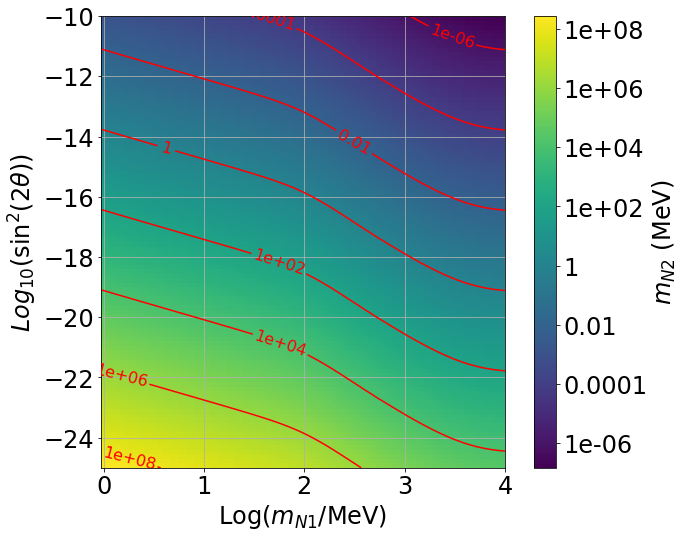

In [6]:
# N1 number density transfers to N2 through boltzmann supression. 
ms2_required = [c.rho_crit_over_hsq*0.12/(ds.compute_current_DM_ndens(T_SM, T_DS)) for T_DS, T_SM in zip(T_DS_dense.flatten(), T_SM_dense.flatten())]
ms2_required = np.array(ms2_required).reshape((len(ms1_dense), len(sinsq2theta_dense)))

plt.figure(figsize=(8,8))
im = plt.imshow(np.log10(ms2_required.T), origin='lower',
                    extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
# Make all the contour lines solid
contours = plt.contour(X, Y, np.log10(ms2_required.T), colors='red', linestyles='solid')
# Put the contour labels as 10^x
def format_func(value, tick_number):
    return r'{:.2g}'.format(10**value)
plt.clabel(contours, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

cb = plt.colorbar(im)
cb.set_label(r'$m_{N2}$ (MeV)')
# Put the colorbar labels as 10^x
cb.formatter = FuncFormatter(format_func)
cb.update_ticks()

plt.xlabel(r'Log($m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
plt.gca().set_aspect(0.3)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.grid()
plt.show()

## Free streaming mass: DEPRECATED

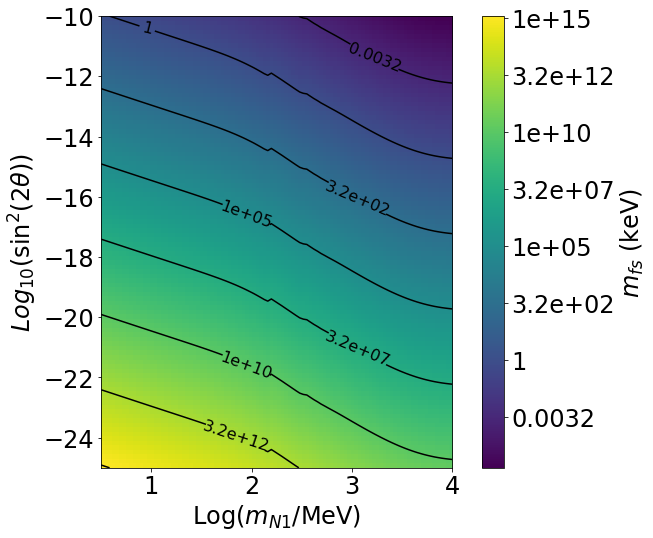

In [6]:
fs_mass = ms2_required/temp_ratio

plt.figure(figsize=(8,8))
im = plt.imshow(np.log10(fs_mass.T), origin='lower',
                    extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
# Make all the contour lines solid
contours = plt.contour(X, Y, np.log10(fs_mass.T), colors='k', linestyles='solid')
# Put the contour labels as 10^x
def format_func(value, tick_number):
    return r'{:.2g}'.format(10**value)
plt.clabel(contours, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

cb = plt.colorbar(im)
cb.set_label(r'$m_{fs}$ (MeV)')
# Put the colorbar labels as 10^x
cb.formatter = FuncFormatter(format_func)
cb.update_ticks()

plt.xlabel(r'Log($m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
plt.gca().set_aspect(0.3)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# Constraints

In [5]:
# Make sure all of the cells above have been run

# Get the angle where ms1 = 3*ms2_required
ms2_func = interpolate.RegularGridInterpolator((ms1_dense, sinsq2theta_dense), ms2_required, method='linear')
ms1_diff = lambda log_sinsq2theta, log_ms1: np.abs(np.log10(3*ms2_func((10**log_ms1, 10**log_sinsq2theta))) - log_ms1)

log_sinsq2theta_equal = []
for log_ms1 in np.log10(ms1_dense):
    guess = -14-2*log_ms1
    log_sinsq2theta_equal.append(optimize.minimize(ms1_diff, guess, args=(log_ms1), bounds=[(np.log10(np.min(sinsq2theta_dense))+0.01, np.log10(np.max(sinsq2theta_dense))-0.01)]).x[0])


# Minimum free streaming mass
fs_limit = 9.7*10**-3 #MeV: from Nadler et. al. 2021

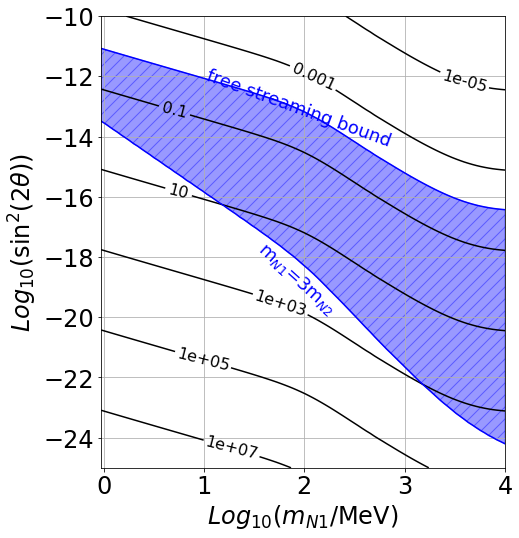

In [7]:
plt.figure(figsize=(8,8))


X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
# Make all the contour lines solid
contours = plt.contour(X, Y, np.log10(ms2_required.T), colors='k', linestyles='solid', alpha=1,
                       levels=np.linspace(-7, 7, 8))
# Put the contour labels as 10^x
def format_func(value, tick_number):
    return r'{:.2g}'.format(10**(value))
plt.clabel(contours, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

plt.xlabel(r'$Log_{10}(m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
plt.gca().set_aspect(0.3)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()

# Constraints

# ms1=3ms2 constraint
plt.plot(np.log10(ms1_dense), log_sinsq2theta_equal, c='b')
plt.annotate('m$_{N1}$=3m$_{N2}$', (1.5, -19.9), fontsize=18, c='b', rotation=-42)

# fs contraints
fs_contour = plt.contour(X, Y, np.log10(ms2_required.T), colors='b', linestyles='solid', levels=[np.log10(fs_limit)])
plt.annotate('free streaming bound', (1, -14.3), fontsize=18, c='b', rotation=-20)
fs_path = fs_contour.collections[0].get_paths()[0]
fs_x_values = fs_path.vertices[:, 0]
fs_y_values = fs_path.vertices[:, 1]

# Hatched region between ms1=ms2 and fs_constraints
fs_interp = interpolate.interp1d(fs_x_values, fs_y_values, kind='linear', bounds_error=False, fill_value='extrapolate')
fs_y_interpolated = fs_interp(np.log10(ms1_dense))
plt.fill_between(np.log10(ms1_dense), log_sinsq2theta_equal, fs_y_interpolated, where=(log_sinsq2theta_equal < fs_y_interpolated), color='blue', hatch='//', alpha=0.4)
plt.grid()

# Set the axes limits
#plt.ylim(-25, -10)
#plt.title(r"Contours: Required m$_{s2}$/MeV for $\Omega_{s2} h^2 = 0.12$", fontsize=18)

plt.show()

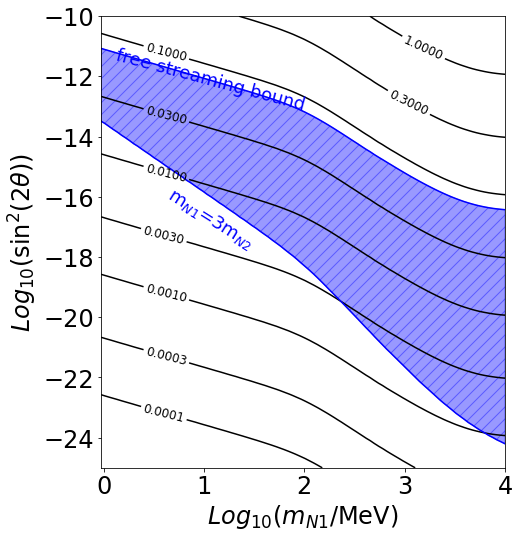

In [8]:
temp_ratio = T_DS_dense_today/c.Tcmb

plt.figure(figsize=(8,8))
# im = plt.imshow(temp_ratio.T, origin='lower',
#                   extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
#                                 np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
levels = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
contours = plt.contour(X, Y, temp_ratio.T, levels, colors='k')
plt.clabel(contours, inline=True, fontsize=12)

plt.xlabel(r'$Log_{10}(m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')

# Constraints

# ms1=3ms2 constraint
plt.plot(np.log10(ms1_dense), log_sinsq2theta_equal, c='b')
plt.annotate('m$_{N1}$=3m$_{N2}$', (0.6, -17.7), fontsize=18, c='b', rotation=-32)

# fs contraints
fs_contour = plt.contour(X, Y, np.log10(ms2_required.T), colors='b', linestyles='solid', levels=[np.log10(fs_limit)])
plt.annotate('free streaming bound', (0.1, -13.1), fontsize=18, c='b', rotation=-15)
fs_path = fs_contour.collections[0].get_paths()[0]
fs_x_values = fs_path.vertices[:, 0]
fs_y_values = fs_path.vertices[:, 1]

# Hatched region between ms1=3ms2 and fs_constraints
fs_interp = interpolate.interp1d(fs_x_values, fs_y_values, kind='linear', bounds_error=False, fill_value='extrapolate')
fs_y_interpolated = fs_interp(np.log10(ms1_dense))
plt.fill_between(np.log10(ms1_dense), log_sinsq2theta_equal, fs_y_interpolated, where=(log_sinsq2theta_equal < fs_y_interpolated), color='blue', hatch='//', alpha=0.4)

# cb = plt.colorbar(im)
# cb.set_label(r'$\frac{T_{DS}}{T_{SM}}$', rotation=0, labelpad=20, fontsize=28)
plt.gca().set_aspect(0.3)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.savefig("plots/temperature_ratio.pdf", bbox_inches='tight')
plt.show()

## Save the data

In [9]:
# Save the data as text files (CSV or any other format you prefer)
np.savetxt('data/results_plot_data/ms1_dense.txt', ms1_dense)
np.savetxt('data/results_plot_data/log_sinsq2theta_equal.txt', log_sinsq2theta_equal)
np.savetxt('data/results_plot_data/X.txt', X)
np.savetxt('data/results_plot_data/Y.txt', Y)
np.savetxt('data/results_plot_data/ms2_required.txt', ms2_required)

# Approximate Analytic Results

## $T_{DS}$

In [ ]:
# The actual data
temp_ratio = T_DS_dense_today/c.Tcmb

# Define the approximate function
def T_DS_approximate(sinsq2theta, ms):
    """Gives the tempreature in MeV"""
    n_dens_conversion = 2*np.pi**2/(3*special.zeta(3)) #divided by m4
    omega_m_hsq = 0.3*(sinsq2theta/10**-10)*(ms/0.1)**2/ms #times m4
    return (c.rho_crit_over_hsq*omega_m_hsq*n_dens_conversion)**(1./3)

# Create an array for the approximate T_DS values
T_DS_approx = []
for ms1 in ms1_dense:
    for sinsq2theta in sinsq2theta_dense:
        T_DS_approx.append(T_DS_approximate(sinsq2theta, ms1))
T_DS_approx = np.array(T_DS_approx).reshape((len(ms1_dense), len(sinsq2theta_dense)))

temp_ratio_approx = T_DS_approx/c.Tcmb

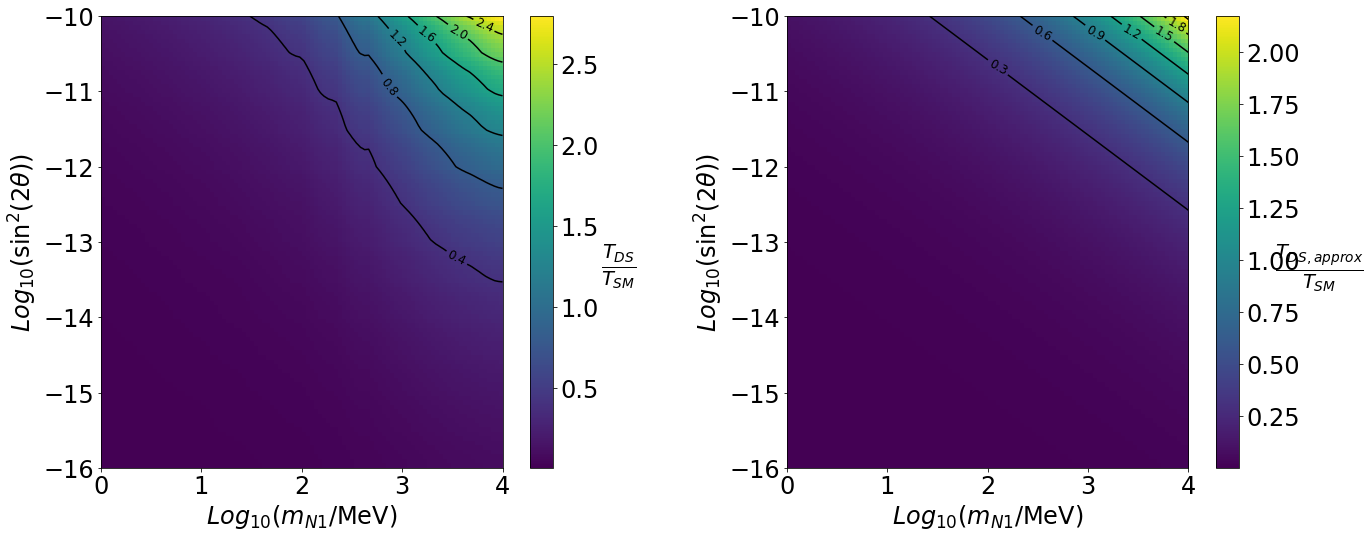

In [ ]:
# Set up the figure and the two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot with real data
im = axs[0].imshow(temp_ratio.T, origin='lower',
                  extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
contours = axs[0].contour(X, Y, temp_ratio.T, colors='k')  # 'k' means black
axs[0].clabel(contours, inline=True, fontsize=12)

axs[0].set_xlabel(r'$Log_{10}(m_{N1}$/MeV)')
axs[0].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')

cb = fig.colorbar(im, ax=axs[0])
cb.set_label(r'$\frac{T_{DS}}{T_{SM}}$', rotation=0, labelpad=20, fontsize=28)
axs[0].set_aspect(0.75)

# Plot with approximate data
im_approx = axs[1].imshow(temp_ratio_approx.T, origin='lower',
                          extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                  np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

contours_approx = axs[1].contour(X, Y, temp_ratio_approx.T, colors='k')  # 'k' means black
axs[1].clabel(contours_approx, inline=True, fontsize=12)

axs[1].set_xlabel(r'$Log_{10}(m_{N1}$/MeV)')
axs[1].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')

cb_approx = fig.colorbar(im_approx, ax=axs[1])
cb_approx.set_label(r'$\frac{T_{DS,approx}}{T_{SM}}$', rotation=0, labelpad=20, fontsize=28)
axs[1].set_aspect(0.75)

# Ensure the layout is tight
plt.tight_layout()
plt.show()


## $m_{s2}$ needed to make all of the dark matter

In [ ]:
# The actual data
ms2_required = [c.rho_crit_over_hsq*0.12/ds.compute_current_DM_ndens(T_SM_final, T_DS) for T_DS in T_DS_dense.flatten()]
ms2_required = np.array(ms2_required).reshape((len(ms1_dense), len(sinsq2theta_dense)))

# The approximate result
def approx_ms2_required(sinsq2theta, ms1):
    return (0.12/0.3)*(10**-10/sinsq2theta)*(0.1/ms1)**2*ms1

# Define the approximate function
def approx_ms2_required(sinsq2theta, ms1):
    return (0.12/0.3)*(10**-10/sinsq2theta)*(0.1/ms1)**2*ms1

ms2_approx_required = [approx_ms2_required(sinsq2theta, ms1) for ms1 in ms1_dense for sinsq2theta in sinsq2theta_dense]
ms2_approx_required = np.array(ms2_approx_required).reshape((len(ms1_dense), len(sinsq2theta_dense)))


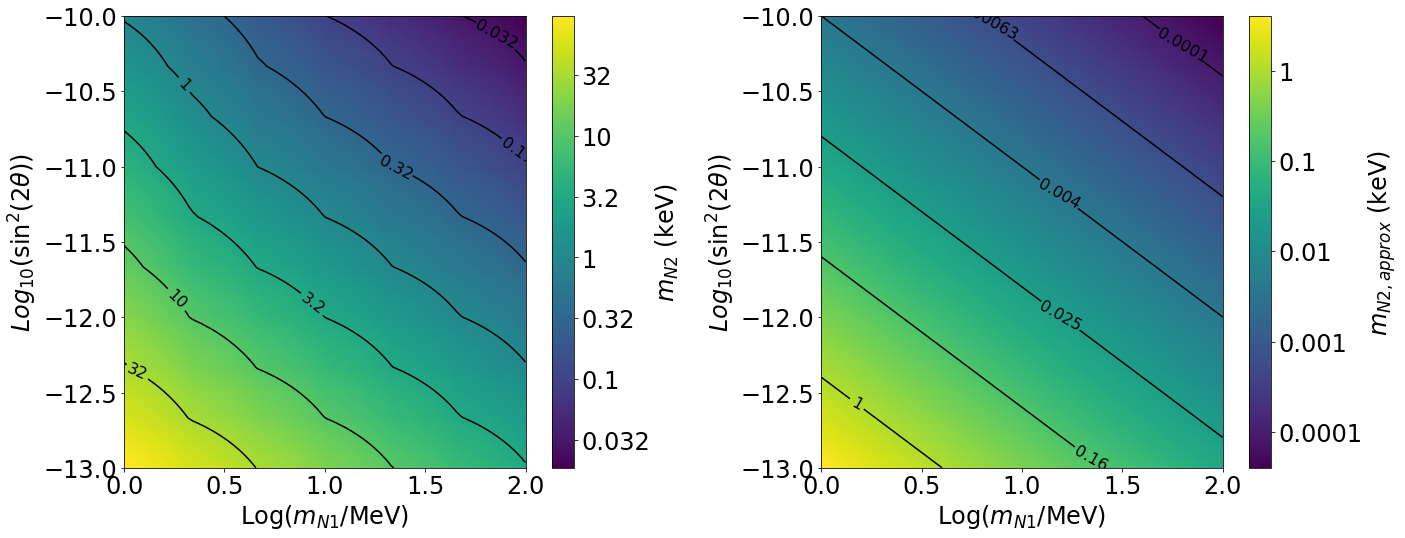

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
# Make all the contour lines solid
contours = axs[0].contour(X, Y, np.log10(ms2_required.T), colors='k', linestyles='solid')
# Put the contour labels as 10^x
def format_func(value, tick_number):
    return r'{:.2g}'.format(10**value)
axs[0].clabel(contours, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

im = axs[0].imshow(np.log10(ms2_required.T), origin='lower',
                    extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])
cb = fig.colorbar(im, ax=axs[0])
cb.set_label(r'$m_{N2}$ (MeV)')
# Put the colorbar labels as 10^x
cb.formatter = FuncFormatter(format_func)
cb.update_ticks()

axs[0].set_xlabel(r'Log($m_{N1}$/MeV)')
axs[0].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
axs[0].set_aspect(0.75)

contours_approx = axs[1].contour(X, Y, np.log10(ms2_approx_required.T), colors='k', linestyles='solid')
axs[1].clabel(contours_approx, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

im_approx = axs[1].imshow(np.log10(ms2_approx_required.T), origin='lower',
                          extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                  np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

cb_approx = fig.colorbar(im_approx, ax=axs[1])
cb_approx.set_label(r'$m_{N2, approx}$ (MeV)')
cb_approx.formatter = FuncFormatter(format_func)
cb_approx.update_ticks()

axs[1].set_xlabel(r'Log($m_{N1}$/MeV)')
axs[1].set_ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
axs[1].set_aspect(0.75)

plt.tight_layout()
plt.show()


# Effective Free streaming mass

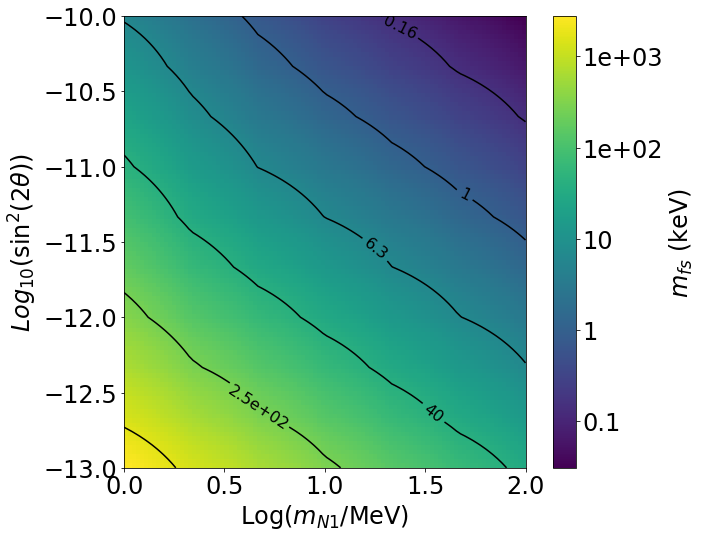

In [ ]:
fs_mass = ms2_required/temp_ratio

plt.figure(figsize=(8,8))
im = plt.imshow(np.log10(fs_mass.T), origin='lower',
                    extent=[np.log10(ms1_dense[0]), np.log10(ms1_dense[-1]),
                                np.log10(sinsq2theta_dense[0]), np.log10(sinsq2theta_dense[-1])])

X, Y = np.meshgrid(np.log10(ms1_dense), np.log10(sinsq2theta_dense))
# Make all the contour lines solid
contours = plt.contour(X, Y, np.log10(fs_mass.T), colors='k', linestyles='solid')
# Put the contour labels as 10^x
def format_func(value, tick_number):
    return r'{:.2g}'.format(10**value)
plt.clabel(contours, inline=True, fontsize=16,  fmt=FuncFormatter(format_func))

cb = plt.colorbar(im)
cb.set_label(r'$m_{fs}$ (keV)')
# Put the colorbar labels as 10^x
cb.formatter = FuncFormatter(format_func)
cb.update_ticks()

plt.xlabel(r'Log($m_{N1}$/MeV)')
plt.ylabel(r'$Log_{10}(\sin^2(2 \theta))$')
plt.gca().set_aspect(0.75)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# Check a single run

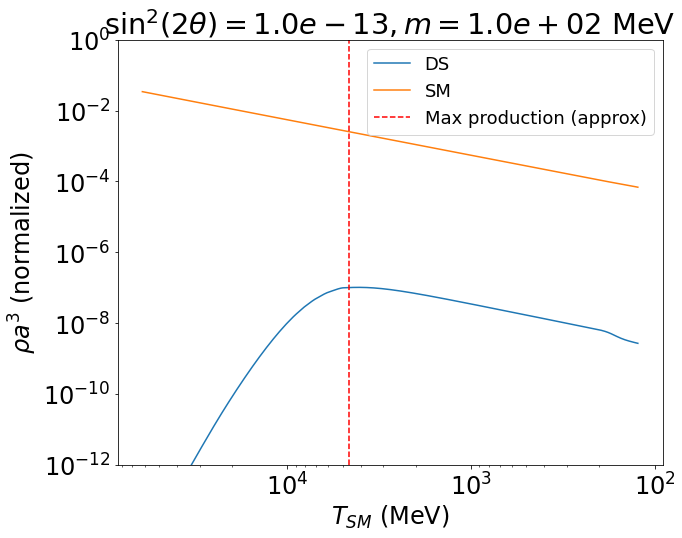

In [ ]:
#import the results from results/test.npy
with open('results/rho_computation_extended.pkl', 'rb') as file:
    results = pickle.load(file)

# Run parameters
theta_idx, ms1_idx = 6, 6
sinsq2theta = results['sinsq2theta_values'][theta_idx]
ms1 = results['ms1_values'][ms1_idx]

# Run results
rho_DS_domain = results['rho_DS_domain'][theta_idx, ms1_idx, :]
T_SM_domain = results['T_SM_domain'][theta_idx, ms1_idx, :]
a_domain = ds.T_SM_to_a(T_SM_domain)
rho_SM_domain = ds.energy_density_func(T_SM_domain)
norm = rho_SM_domain[-1]*a_domain[-1]**4

# Plot
plt.figure(figsize=(10, 8))
plt.loglog(T_SM_domain, rho_DS_domain*a_domain**3/norm, label=r"DS")
plt.loglog(T_SM_domain, rho_SM_domain*a_domain**3/norm, label=r"SM")
plt.axvline(sid.Tmax(ms1), ls='--', c='r', label='Max production (approx)')

plt.xlabel(r"$T_{SM}$ (MeV)")
plt.ylabel(r"$\rho a^3$ (normalized)")
plt.gca().invert_xaxis()
plt.legend(fontsize=18)
plt.ylim(10**-12, 1)
plt.title(r"$\sin^2(2\theta) = {:.1e}, m = {:.1e}$ MeV".format(sinsq2theta, ms1))
plt.tight_layout()
plt.show()

Temperature

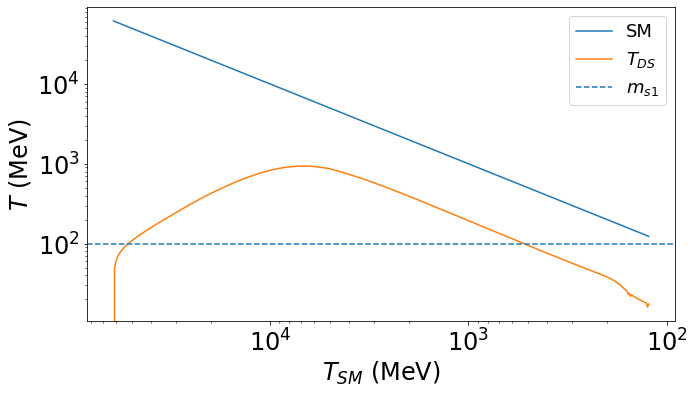

In [ ]:
#import the results from results/test.npy
with open('results/rho_computation_extended.pkl', 'rb') as file:
    results = pickle.load(file)

# Run parameters
theta_idx, ms1_idx = 6, 6
sinsq2theta = results['sinsq2theta_values'][theta_idx]
ms1 = results['ms1_values'][ms1_idx]

# Run results
rho_DS_domain = results['rho_DS_domain'][theta_idx, ms1_idx, :]
T_DS_domain = [ds.find_T_DS_from_rho(rho, ms1, 0)[0] for rho in rho_DS_domain]
T_SM_domain = results['T_SM_domain'][theta_idx, ms1_idx, :]

# Plot
plt.figure(figsize=(8, 7))
plt.loglog(T_SM_domain, T_SM_domain, label=r"SM")
plt.loglog(T_SM_domain, T_DS_domain, label=r"$T_{DS}$")
plt.axhline(ms1, label=r"$m_{s1}$", linestyle="--")

plt.xlabel(r"$T_{SM}$ (MeV)")
plt.ylabel(r"$T$ (MeV)")
plt.tight_layout()
plt.gca().invert_xaxis()
plt.legend(fontsize=18)
plt.show()

# Check a grid of the final temperatures

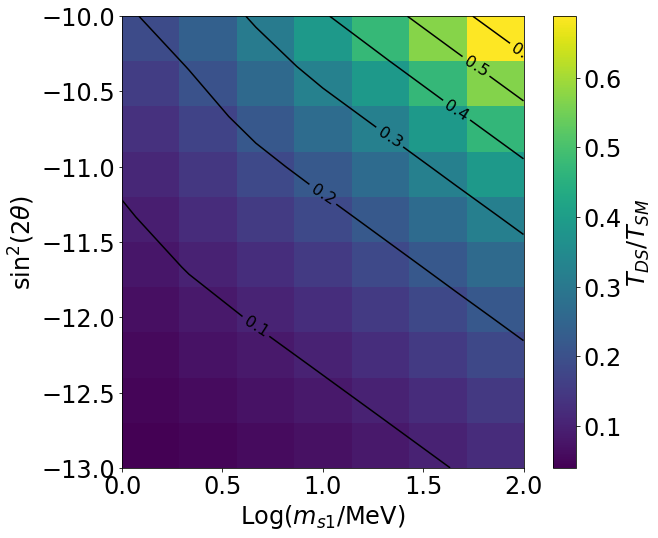

In [ ]:
# Load a pickle file with the data
with open('data/T_DS_results.pkl', 'rb') as file:
    data_dict = pickle.load(file)

T_SM_final = data_dict['T_SM_domain'][-1]
temp_ratio = data_dict['T_DS_domain'][:,:,0,-1]/T_SM_final

plt.figure(figsize=(8,8))
im = plt.imshow(temp_ratio, origin='lower',
                  extent=[np.log10(data_dict['ms1_values'][0]), np.log10(data_dict['ms1_values'][-1]),
                                np.log10(data_dict['sinsq2theta_values'][0]), np.log10(data_dict['sinsq2theta_values'][-1])])

X, Y = np.meshgrid(np.log10(data_dict['ms1_values']), np.log10(data_dict['sinsq2theta_values']))
contours = plt.contour(X, Y, temp_ratio, colors='k')  # 'k' means black
plt.clabel(contours, inline=True, fontsize=16)

plt.xlabel(r'Log($m_{s1}$/MeV)')
plt.ylabel(r'$\sin^2(2 \theta)$')

cb = plt.colorbar(im)
cb.set_label(r'$T_{DS}/T_{SM}$')
plt.gca().set_aspect(0.75)
# Make the colorbar size the same as the plot
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()



# Proof that $\theta$ dependence is analytic

In [23]:
# Load the pickle file with the data
with open('results/rho_computation.pkl', 'rb') as file:
    data_dict = pickle.load(file)

rho_DS_final = data_dict['rho_DS_domain'][:,:,-1]

# Get the final dark sector temperature for each point in the parameter space
ms1_values = data_dict['ms1_values']
sinsq2theta_values = data_dict['sinsq2theta_values']

In [25]:
# Choose any theta index. Rho depends linearly on sinsq2theta.
idx0, idx1 = 0, -1
sinsq2theta0, sinsq2theta1 = sinsq2theta_values[idx0], sinsq2theta_values[idx1]
print(rho_DS_final[idx0,:]/sinsq2theta0)
print(rho_DS_final[idx1,:]/sinsq2theta1)
fractional_difference = (rho_DS_final[idx0,:] - rho_DS_final[idx1,:]sinsq2theta0/sinsq2theta1)
print(f"Fractional difference={(rho_DS_final[idx0,:]/sinsq2theta0 - rho_DS_final[idx1,:]/sinsq2theta1)/

[1.58166006e+12 2.53484232e+13 4.16465438e+14 6.90631143e+15
 1.59716598e+17 9.48308172e+18 1.49743525e+21 3.00360711e+22
 2.92458507e+23]
[1.58166006e+12 2.53484232e+13 4.16465438e+14 6.90631143e+15
 1.59716598e+17 9.48308172e+18 1.49743525e+21 3.00360711e+22
 2.92458507e+23]
difference=[3.31572266e+01 5.34378906e+02 8.80343750e+03 1.46775000e+05
 3.31046400e+06 1.68101888e+08 2.97892577e+10 6.71055086e+11
 7.67242220e+12]
